In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Prepare Data

In [2]:
# Only NEM capital cities at the moment, bu can add more if desired
regions = ['1GSYD', '2GMEL', '3GBRI', '4GADE', '6GHOB', '8ACTE']
base_path = Path('/g/data/gb02/cd3022/hot-and-cloudy/solar-pv/GCCSA/actual/')
# Months to load in
months = ['01', '02', '03', '11', '12']

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = []
    for m in months:
        files.extend(list(file_path.rglob(f"*-{m}-*.nc")))
    ds_region = xr.open_mfdataset(files, combine='by_coords', chunks='auto')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
# ds = ds.load()
# Assign Brisbane time (standard for energy market
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


### Remove the missing timestep from each day

In [3]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

### Remove 3 bad days of Himawari data

In [4]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

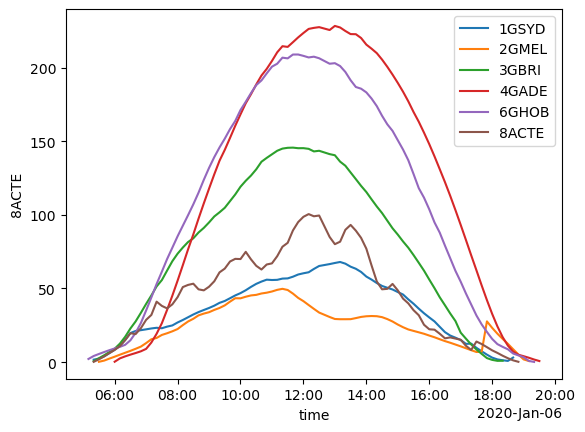

In [5]:
for reg in regions:
    ds[reg].sel(time='2020-01-06').plot(label=reg)
    plt.legend()